In [2]:
from detection_utils import collate_fn
from utils_dataset import get_transform_albumentation

%matplotlib inline
import matplotlib.pyplot as plt

import os
import re
import io
import random
import contextlib
import numpy as np
from PIL import Image

import torch
import torchvision

from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks
from torch.utils.data import Dataset, DataLoader

import sys
import albumentations as A
import imgaug.augmenters as iaa
from pycocotools.coco import COCO

In [3]:
# set seed
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("Seed set!")

seed_torch()

Seed set!


# Helper Functions

In [4]:
# Suppresses Output (specific print-statements)
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.StringIO()
    yield
    sys.stdout = save_stdout

In [5]:
# extract coco-informations
def extract_coco_annotations(file_path, idx):
    coco_annotation = COCO(annotation_file=file_path)
    
    category_ids = coco_annotation.getCatIds()
    categories = coco_annotation.loadCats(category_ids)
    category_names = [cat["name"] for cat in categories]
    query_id = category_ids[0]

    img_ids = coco_annotation.getImgIds(catIds=[query_id])
    img_id = img_ids[idx]

    ann_ids = coco_annotation.getAnnIds(imgIds=[img_id], iscrowd=None)
    anns = coco_annotation.loadAnns(ann_ids)
    mask = coco_annotation.annToMask(anns[0])

    new_mask = torch.zeros(size=(len(anns), mask.shape[0], mask.shape[1]))

    for i in range(0, len(anns)):
        new_mask[i] = new_mask[i] + coco_annotation.annToMask(anns[i])

    return anns, category_names, new_mask

In [6]:
# albumentation-composition of transformations
def get_transform_albumentation(train, seed=42):
    transform = []
    # rotate_method="ellipse" -> BBs ein wenig zu klein | rotate_method="largest_box" -> BBs ein wenig zu groß / quadratisch
    transform.append(A.Rotate(limit=[39.925, 39.925], always_apply=True, crop_border=True, rotate_method="ellipse"))
    if train:
        transform.append(A.Affine(rotate=[-15, 15], p=0.5))
        transform.append(A.RandomCrop(height=192, width=192, p=0.5))
        transform.append(A.BBoxSafeRandomCrop(erosion_rate=0.2, p=0.5)) 
        transform.append(A.Flip(p=0.5))
        transform.append(A.RandomBrightnessContrast(p=0.2))
        transform.append(A.OneOf([
                            A.PixelDropout(p=0.6),
                            A.Perspective(p=0.4)
                            ], p=1))
        return A.Compose(transform, bbox_params=A.BboxParams(format='coco', label_fields=["class_labels"]))

# Class for Dataset creation

In [7]:
# inspired by: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
class WheatDataset(Dataset):
    def __init__(self, root, transforms, plot):
        self.root = root
        self.transforms = transforms
        self.plot = plot

        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annotations_path = os.path.join(self.root, "annotations.json")

    def __getitem__(self, idx):
        # loads picture
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = np.array(Image.open(img_path).convert("RGB"))

        # get bbox, area, segmentation, classes, and mask
        with nostdout():
            anno, class_name, mask = extract_coco_annotations(self.annotations_path, idx)
        boxes, classes, area, segmentations = [], [], [], []
        for dict in anno:
            segmentations.append(dict["segmentation"])
            boxes.append(dict["bbox"])
            area.append(dict["area"])
            classes.append(class_name)
        
        # convert and create target
        boxes = torch.as_tensor(boxes, dtype=torch.float32).numpy()
        mask = mask.to(dtype=torch.uint8).permute(1,2,0).numpy()
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        img_id = int(re.findall(r'\d+', img_path)[-2])
        image_id = torch.tensor([img_id])
        anno_idx = torch.tensor([idx+1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(boxes)), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["masks"] = mask
        target["labels"] = labels
        target["image_id"] = image_id
        target["anno_idx"] = anno_idx
        target["area"] = area
        target["iscrowd"] = iscrowd
        

        # transform img, bboxes and img
        if self.transforms is not None:
            transformed = self.transforms(
                                image=img, 
                                mask=target["masks"], 
                                bboxes=target["boxes"], 
                                class_labels=target["labels"])

            img = torch.from_numpy(transformed['image']).permute(2,0,1).to(torch.float32) / 255
            target["masks"] = torch.from_numpy(transformed['mask']).to(torch.uint8).permute(2,0,1)
            target["boxes"] = box_convert(torch.Tensor(transformed["bboxes"]), "xywh", "xyxy").to(torch.float32)
            
            """
            img     ->      (C x H x W)     -> torch.Tensor
            boxes   ->      (N x H x W)     -> torch.Tensor
            masks   ->      (N x H x W)     -> torch.Tensor
            """

        # plot img + boxes + masks
        if self.plot:
            bboxes = draw_bounding_boxes((img*255).to(torch.uint8), target["boxes"], colors=(255,0,0))
            masks = draw_segmentation_masks(bboxes, (target["masks"].sum(dim=0)) > 0, colors=(0,0,255), alpha=0.5)
            fig, ax = plt.subplots(figsize=(14, 11))
            plt.imshow(masks.permute(1,2,0))

        return img, target

    def __len__(self):
        return len(self.imgs)

Img_id: 100
Anno: tensor([1])
Boxes: 43


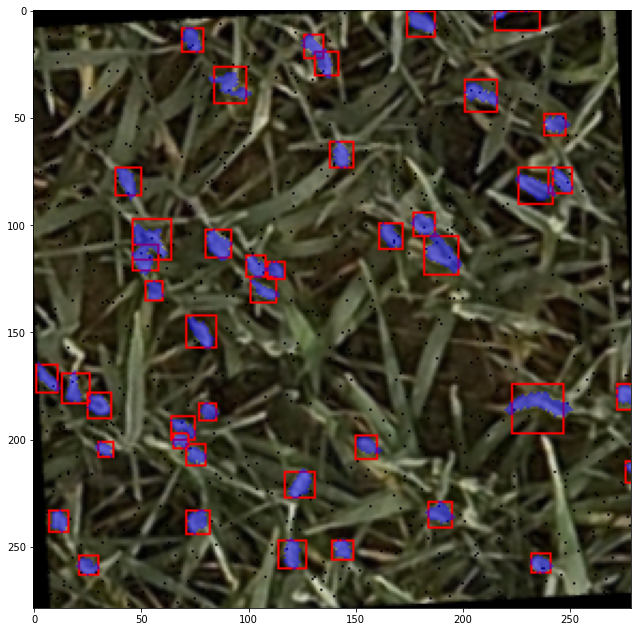

In [8]:
if __name__ == "__main__":
    root = "/data/departments/schoen/roessle/HSWT_Aehrenzaehlen/"
    batch_size = 4
    num_workers = 4

    dataset = WheatDataset(root=root, transforms=get_transform_albumentation(train=True), plot=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)

    dataset[0]